# Open source libraries

In [50]:
import os
import spectral 
import seaborn as sns
import gdal
import glob
from detecto import core, utils, visualize
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import utm
import numpy as np
import multiprocessing

import warnings
warnings.filterwarnings("ignore")

In [51]:
def open_image(img_path):

    tif_img = gdal.Open(img_path).ReadAsArray()
    a_img = cv2.cvtColor(tif_img, cv2.COLOR_GRAY2BGR)
    a_img = cv2.normalize(a_img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     tif_img = None
    return a_img, tif_img

# --------------------------------------------------
def get_plot_number(img_path):
    
    plot_number = os.path.basename(img_path.strip('_ortho.tif'))
    
    return plot_number

# --------------------------------------------------
def get_min_max(box):

    min_x, min_y, max_x, max_y = int(box[0]), int(box[1]), int(box[2]), int(box[3])

    return min_x, min_y, max_x, max_y

# --------------------------------------------------
def pixel2geocoord(one_img, x_pix, y_pix):
    ds = gdal.Open(one_img)
    c, a, b, f, d, e = ds.GetGeoTransform()
    lon = a * int(x_pix) + b * int(y_pix) + a * 0.5 + b * 0.5 + c
    lat = d * int(x_pix) + e * int(y_pix) + d * 0.5 + e * 0.5 + f

    return (lat, lon)

# --------------------------------------------------
def get_stats(img):
    img = img[~np.isnan(img)]

    mean = np.mean(img) #- 273.15
    median = np.percentile(img, 50)

    q1 = np.percentile(img, 25)
    q3 = np.percentile(img, 75)

    var = np.var(img)
    sd = np.std(img)

    return mean, median, q1, q3, var, sd

# --------------------------------------------------
def kmeans_temp(img):

#     img = img[~np.isnan(img)]

    pixel_vals = img.reshape((-1,1))
    pixel_vals = np.float32(pixel_vals)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1.0)
    k = 9
    retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((img.shape))
    low_thresh = np.unique(segmented_image)[:1][0]
    upp_thresh = np.unique(segmented_image)[1:2][0]
    img[segmented_image > upp_thresh] = np.nan

    mean, median, q1, q3, var, sd = get_stats(img)

    return mean, median, q1, q3, var, sd, img

# --------------------------------------------------
def detect_plants(img):
    
    a_img, tif_img = open_image(img)
    a_img[a_img==0] == np.nan
    plot_num = get_plot_number(img)

    predictions = model.predict(a_img)
    labels, boxes, scores = predictions
    plant_detection_dict = {}
    cnt = 0
    
    try:
        for i, box in enumerate(boxes):
            cnt += 1
            
            if scores[i] >= 0.98:
                
                min_x, min_y, max_x, max_y = get_min_max(box)
                center_x, center_y = ((max_x+min_x)/2, (max_y+min_y)/2)
                nw_lat, nw_lon = pixel2geocoord(img, min_x, max_y)
                se_lat, se_lon = pixel2geocoord(img, max_x, min_y)

                nw_e, nw_n, _, _ = utm.from_latlon(nw_lat, nw_lon, 12, 'N')
                se_e, se_n, _, _ = utm.from_latlon(se_lat, se_lon, 12, 'N')

                area_sq = (se_e - nw_e) * (se_n - nw_n)
                lat, lon = pixel2geocoord(img, center_x, center_y)

                new_img = tif_img[min_y:max_y, min_x:max_x]
                new_img = np.array(new_img)
                copy = new_img.copy()

                mean, median, q1, q3, var, sd, seg_img = kmeans_temp(copy)
                plant_detection_dict[cnt] = {
                    
                    'plot': plot_num, 
                    'median': median,
                    'mean': mean,
                    'standard_deviation': sd,
                    'area_m2': area_sq
                    
                }
                
    except:
        pass
    tif_img = None
    a_img = None
    new_img = None
    return plant_detection_dict
    
# --------------------------------------------------
def get_r_squared(final_df):
    correlation_matrix = np.corrcoef(final_df['area_m2'], final_df['median'])
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2

    return r_squared


In [52]:
img_list = glob.glob('./2021-07-28_data/*_ortho.tif')

In [53]:
model = core.Model.load('./model_weights_sorghum_flir.pth', ['lettuce'])

# Pipeline overview

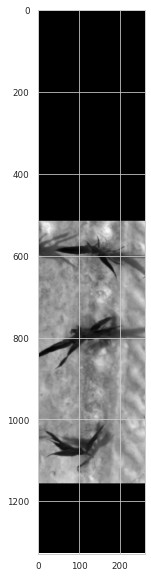

tensor([0.9990, 0.9945, 0.9935, 0.9715, 0.2490, 0.0831, 0.0773, 0.0552])


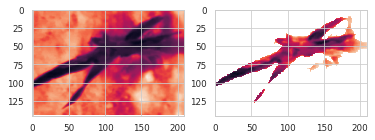

Median temperature: 39.16975402832031
Standard deviation: 2.004619598388672



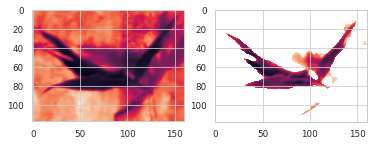

Median temperature: 39.27288818359375
Standard deviation: 1.6735756397247314



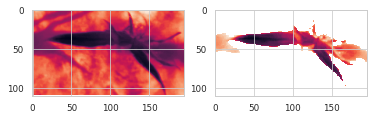

Median temperature: 40.497249603271484
Standard deviation: 2.4374167919158936



In [54]:
for img in img_list[4:5]:
    plot_num = get_plot_number(img)
    
    a_img, tif_img = open_image(img)
    plt.figure(figsize=(15,10))
    plt.imshow(a_img)
    plt.show()  # display it
    a_img[a_img==0] == np.nan

    predictions = model.predict(a_img)
    labels, boxes, scores = predictions
    print(scores)
    try:
        for i, box in enumerate(boxes):
            if scores[i] >= 0.98:

                min_x, min_y, max_x, max_y = get_min_max(box)
                center_x, center_y = ((max_x+min_x)/2, (max_y+min_y)/2)
                nw_lat, nw_lon = pixel2geocoord(img, min_x, max_y)
                se_lat, se_lon = pixel2geocoord(img, max_x, min_y)

                nw_e, nw_n, _, _ = utm.from_latlon(nw_lat, nw_lon, 12, 'N')
                se_e, se_n, _, _ = utm.from_latlon(se_lat, se_lon, 12, 'N')

                area_sq = (se_e - nw_e) * (se_n - nw_n)
                lat, lon = pixel2geocoord(img, center_x, center_y)

                new_img = tif_img[min_y:max_y, min_x:max_x]
                new_img = np.array(new_img)
                copy = new_img.copy()

                mean, median, q1, q3, var, sd, seg_img = kmeans_temp(copy)
                fig, ax = plt.subplots(1,2)
                ax[0].imshow(new_img, cmap=None);
                ax[1].imshow(seg_img, cmap=None);
                plt.show()
                plt.close()

                print(f'Median temperature: {median}\nStandard deviation: {sd}\n')
                
    except:
        pass

# Detecting individual plants for multiple images

In [55]:
final_df_list = []

for img in img_list[10:15]:
    df = detect_plants(img)
    df = pd.DataFrame.from_dict(df, orient='index')
    final_df_list.append(df)
    
final_df = pd.concat(final_df_list)

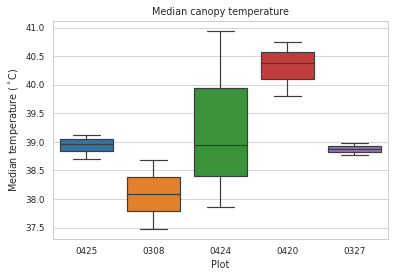

In [56]:
sns.set_context("paper")
sns.set_style("whitegrid")

sns.boxplot(x='plot', 
            y='median', 
           data= final_df)

plt.title('Median canopy temperature')
plt.xlabel('Plot')
plt.ylabel('Median temperature ($^\circ$C)');

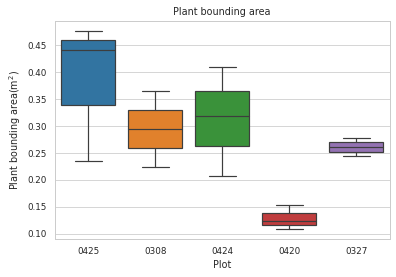

In [57]:
sns.boxplot(x='plot', 
            y='area_m2', 
           data= final_df)

plt.title('Plant bounding area')
plt.xlabel('Plot')
plt.ylabel('Plant bounding area(m$^2$)');

R squared: 0.2732417680973346


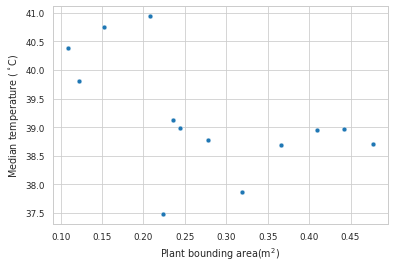

In [58]:
sns.scatterplot(x='area_m2',
                y='median', 
                data=final_df)
plt.xlabel('Plant bounding area(m$^2$)')
plt.ylabel('Median temperature ($^\circ$C)')
print(f'R squared: {get_r_squared(final_df)}')